In [8]:
from sklearn.linear_model import LinearRegression
import pickle
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
%matplotlib inline
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [9]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

def mape_error(y_true, y_pred):
    return -np.sqrt(np.sum((y_pred - y_true) * (y_pred - y_true)) * 1.0 / y_true.shape[0])

def scoring(reg, x, y):
    pred = reg.predict(x)
    return smape(pred, y)

def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + y_pred) * 2)

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg")
    plt.plot([min_val, max_val], [min_val, max_val],'m--')
    plt.title(title, fontsize=9)
    plt.show()

In [10]:
gbm = read_pkl("London/lightgbm_PM25.model")
lr = read_pkl("London/LR_PM251.model")
xgb = read_pkl("London/xgboost_PM25.model")

/Users/yulynn/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/yulynn/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
# load the whole size dataset
X = np.load("London/X_test.npy")
Y_PM25 = np.load("London/Y_PM25_test.npy")
Y_PM10 = np.load("London/Y_PM10_test.npy")
Y_No2 = np.load("London/Y_NO2_test.npy")

In [24]:
# split the Y_PM25, X into training part and testing part
train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10 = train_test_split(X, Y_PM10, test_size=0.2, random_state=11)
print(train_X_PM10.shape, test_X_PM10.shape, train_Y_PM10.shape, test_Y_PM10.shape)

(216652, 198) (54164, 198) (216652,) (54164,)


In [26]:
# split the Y_PM25, X into training part and testing part
train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_No2, test_size=0.2, random_state=11)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(216652, 198) (54164, 198) (216652,) (54164,)


In [12]:
# split the Y_PM25, X into training part and testing part
train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25 = train_test_split(X, Y_PM25, test_size=0.2, random_state=11)
print(train_X_PM25.shape, test_X_PM25.shape, train_Y_PM25.shape, test_Y_PM25.shape)

(216652, 198) (54164, 198) (216652,) (54164,)


# Ensemble blending get predict result

In [13]:
xgb_val_pred=xgb.predict(train_X_PM25)
xgb_test_pred=xgb.predict(test_X_PM25)

In [14]:
lightgbm_val_pred=gbm.predict(train_X_PM25)
lightgbm_test_pred=gbm.predict(test_X_PM25)

In [15]:
lr_val_pred=lr.predict(train_X_PM25)
lr_test_pred=lr.predict(test_X_PM25)

# Create new datasets with the predictions from first level models.

In [16]:
# to-do-list: model ensemble
#Ensembling
#To combine the 1st level model predictions,use a simple linear regression.
#feeding the model with predictions&don't need a complex model
#1st level: XGboost,lightbgm,linear regression
#2st level: Linear Regression
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(lightgbm_val_pred, columns=['lightgbm'])
first_level['xgb'] = xgb_val_pred
first_level['linear_regression'] = lr_val_pred
#first_level['knn'] = lr_val_pred
#first_level['label'] = Y_PM25.values
first_level.head(20)

,lightgbm,xgb,linear_regression
0,11.657157,19.450005,12.615177
1,7.678498,9.337333,8.109863
2,9.225338,8.898109,10.997403
3,6.698435,10.503695,5.357722
4,7.045057,10.534971,5.736983
5,16.657346,18.440132,19.210831
6,9.117873,13.280671,9.340655
7,11.557580,21.794020,11.155716
8,6.518597,9.468546,3.905649
9,6.961751,10.781061,6.105017


In [17]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(lightgbm_test_pred, columns=['lightgbm'])
first_level_test['xgb'] = xgb_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test.head()

,lightgbm,xgb,linear_regression
0,10.863602,16.267586,10.868811
1,10.693937,12.573215,11.335568
2,1.949258,6.792130,-0.802689
3,6.099091,10.253236,5.340764
4,7.327809,13.342678,11.539936


# 2nd level model as a linear regression/or others

In [4]:
meta_model = read_pkl("London/ensemble_PM25.model")

In [18]:
meta_model = LinearRegression(n_jobs=-1)
#first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, train_Y_PM25)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [17]:
save_pkl("London/ensemble_PM25.model", meta_model)

In [19]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [20]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, train_Y_PM25)))

Train rmse: 4.192137665511913


In [21]:
print('test smape:', np.mean(np.abs(train_Y_PM25 - ensemble_pred) / (train_Y_PM25 + ensemble_pred) * 2))

test smape: 0.30198895198753567


/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


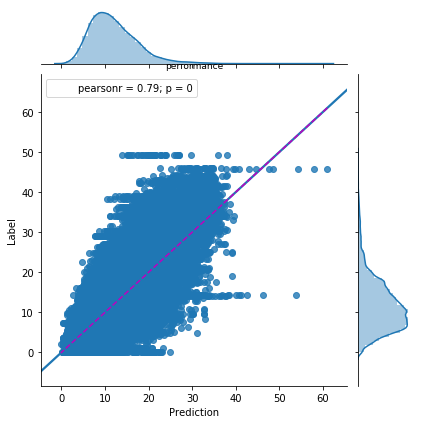

In [22]:
model_performance_sc_plot(ensemble_pred, train_Y_PM25, 'performance')

In [27]:
xgb_val_pred=xgb.predict(train_X_PM10)
xgb_test_pred=xgb.predict(test_X_PM10)
lightgbm_val_pred=gbm.predict(train_X_PM10)
lightgbm_test_pred=gbm.predict(test_X_PM10)
lr_val_pred=lr.predict(train_X_PM10)
lr_test_pred=lr.predict(test_X_PM10)

In [28]:
# to-do-list: model ensemble
#Ensembling
#To combine the 1st level model predictions,use a simple linear regression.
#feeding the model with predictions&don't need a complex model
#1st level: XGboost,lightbgm,linear regression
#2st level: Linear Regression
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(lightgbm_val_pred, columns=['lightgbm'])
first_level['xgb'] = xgb_val_pred
first_level['linear_regression'] = lr_val_pred
#first_level['knn'] = lr_val_pred
#first_level['label'] = Y_PM25.values
first_level.head(20)

,lightgbm,xgb,linear_regression
0,11.657157,19.450005,12.615177
1,7.678498,9.337333,8.109863
2,9.225338,8.898109,10.997403
3,6.698435,10.503695,5.357722
4,7.045057,10.534971,5.736983
5,16.657346,18.440132,19.210831
6,9.117873,13.280671,9.340655
7,11.557580,21.794020,11.155716
8,6.518597,9.468546,3.905649
9,6.961751,10.781061,6.105017


In [29]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(lightgbm_test_pred, columns=['lightgbm'])
first_level_test['xgb'] = xgb_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test.head()

,lightgbm,xgb,linear_regression
0,10.863602,16.267586,10.868811
1,10.693937,12.573215,11.335568
2,1.949258,6.792130,-0.802689
3,6.099091,10.253236,5.340764
4,7.327809,13.342678,11.539936


In [32]:
meta_model = LinearRegression(n_jobs=-1)
#first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, train_Y_PM10)
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [34]:
print('test smape:', np.mean(np.abs(train_Y_PM10 - ensemble_pred) / (train_Y_PM10 + ensemble_pred) * 2))

test smape: 0.2822857407110573


/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


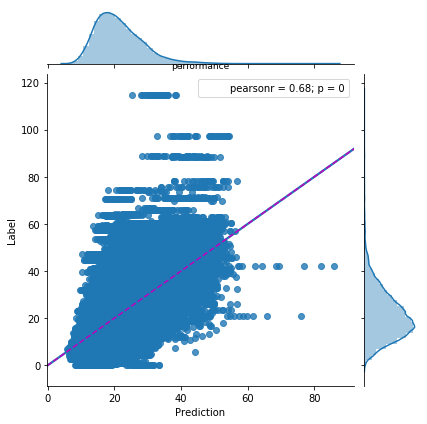

In [35]:
model_performance_sc_plot(ensemble_pred, train_Y_PM10, 'performance')

In [36]:
xgb_val_pred=xgb.predict(train_X_NO2)
xgb_test_pred=xgb.predict(test_X_NO2)
lightgbm_val_pred=gbm.predict(train_X_NO2)
lightgbm_test_pred=gbm.predict(test_X_NO2)
lr_val_pred=lr.predict(train_X_NO2)
lr_test_pred=lr.predict(test_X_NO2)

In [37]:
# to-do-list: model ensemble
#Ensembling
#To combine the 1st level model predictions,use a simple linear regression.
#feeding the model with predictions&don't need a complex model
#1st level: XGboost,lightbgm,linear regression
#2st level: Linear Regression
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(lightgbm_val_pred, columns=['lightgbm'])
first_level['xgb'] = xgb_val_pred
first_level['linear_regression'] = lr_val_pred
#first_level['knn'] = lr_val_pred
#first_level['label'] = Y_PM25.values
first_level.head(20)

,lightgbm,xgb,linear_regression
0,11.657157,19.450005,12.615177
1,7.678498,9.337333,8.109863
2,9.225338,8.898109,10.997403
3,6.698435,10.503695,5.357722
4,7.045057,10.534971,5.736983
5,16.657346,18.440132,19.210831
6,9.117873,13.280671,9.340655
7,11.557580,21.794020,11.155716
8,6.518597,9.468546,3.905649
9,6.961751,10.781061,6.105017


In [38]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(lightgbm_test_pred, columns=['lightgbm'])
first_level_test['xgb'] = xgb_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test.head()

,lightgbm,xgb,linear_regression
0,10.863602,16.267586,10.868811
1,10.693937,12.573215,11.335568
2,1.949258,6.792130,-0.802689
3,6.099091,10.253236,5.340764
4,7.327809,13.342678,11.539936


In [39]:
meta_model = LinearRegression(n_jobs=-1)
#first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, train_Y_NO2)
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [40]:
print('test smape:', np.mean(np.abs(train_Y_NO2 - ensemble_pred) / (train_Y_NO2 + ensemble_pred) * 2))

test smape: 0.4989923227606918


/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yulynn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


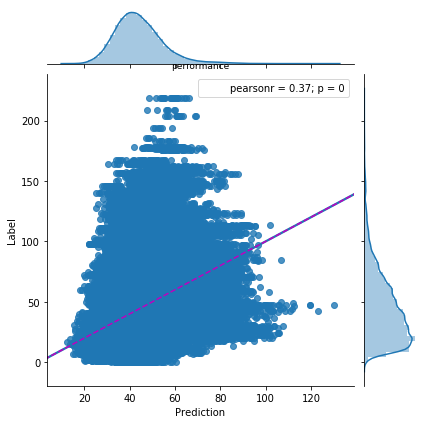

In [41]:
model_performance_sc_plot(ensemble_pred, train_Y_NO2, 'performance')